In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve

<b> Obtain spectrum data from FITS file </b>

In [2]:
# For synthetic spectra (like M_p5500g4.0z0.00t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec.FITS)

def get_intensity_wavelength(filename):
    hdul_image_synth = fits.open(filename)

    synth_data_1 = hdul_image_synth[1].data
    wavelength_synth = synth_data_1['wavelength']
    flux_synth = synth_data_1['flux']
    normalized_flux_synth = synth_data_1['normalized flux']

    return wavelength_synth, flux_synth, normalized_flux_synth

In [3]:
def get_intensity_wavelength_star(filename,lambda_min,lambda_max):
    '''Dado o ficheiro fits e os limites de comprimento de onda, devolve o array de fluxo e o de comprimento de onda'''
    
    #carregar o header e definir o pixel de referência (é necessário fazer um 'try' porque a estrela2 não tem 'CRPIX1')
    header=fits.getheader(filename)
    
    try:
        ref_px=header['CRPIX1']
    except KeyError:
        ref_px=1
    
    #carregar os dados
    data=fits.getdata(filename)
    ln=len(data)
    
    #definir o lambda no pixel de referência e os delta-lambda
    val=header['CRVAL1']
    delt=header['CDELT1']
    
    #criar array dos lambdas
    wavelength=np.arange(val+(1-ref_px)*delt,val+(ln-ref_px)*delt,delt)
    
    #limitar os lambdas aos limites impostos
    mask = (wavelength >= lambda_min) & (wavelength <= lambda_max)
    wv_filtered=wavelength[mask]
    
    #limitar o fluxo aos limites de lambda impostos
    data_filtered=data[mask]
    
    return wv_filtered, data_filtered

In [4]:
filename = '../Project2/spectral_tests/M_p5500g4.0z0.00t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec.FITS'

In [5]:
filename_2 = '../Project2/Dados_Trab2/estrela1.fits'

In [6]:
wavelength_synth, flux_synth, normalized_flux_synth_file = get_intensity_wavelength(filename)

<b> Resolving Power (R = lambda/ delta_lambda) </b>

lambda = average wavelength
delta_lambda = FWHM

* R < 1000 (low resolution)
* 1000 < R < 50000 (intermidiate resolution)
* R > 50000 (high resolution)
* R > 500000 (very high resolution)

In [7]:
# R is assumed to be = 40000
R = 40000

<b> FWHM (delta lambda) - Chromatic Resolution</b>

* FWHM = 2 * sqrt(2*ln(2)) * sigma

In [8]:
def fwhm(wavelength, resolvent_power):

    wavelength_avg = np.mean(wavelength)

    return wavelength_avg/resolvent_power

#fwhm = fwhm(wv_mean, R)

In [9]:
#fwhm

<b> Sigma for Gaussian </b>

In [10]:
def sigma_gaussian(fwhm):
    const = 2 * np.sqrt(2*np.log(2))

    return fwhm/const

#sigma = sigma_gaussian(fwhm)

<b> Espetro Simulado </b>

In [11]:
def P(wavelength, resolvent_power):
    # wavelentgth mean
    wv_mean = wavelength.mean()

    # fwhm
    fwhm_v = fwhm(wv_mean, resolvent_power)

    # sigma
    sigma = sigma_gaussian(fwhm_v)
    
    # Construir a gaussiana
    pixel_size = wavelength[1] - wavelength[0]  # Supor um tamanho de pixel em Å (pequeno para alta resolução)
    xx = np.arange(-6 * sigma, 6 * sigma, pixel_size)  # Intervalo centrado em zero
    gaussian_profile = np.exp(-0.5 * (xx / sigma) ** 2)
    gaussian_profile /= gaussian_profile.sum()  # Normalizar a gaussiana

    return xx, gaussian_profile

xx, P_spectrum = P(wavelength_synth, 40000)
#P = P(wavelength_synth, R)
# E = F (conv) P

In [12]:
''' 
Subsituir sufbfunções pelo P (gaussian profile)
'''
def plot_gaussian_P(wavelength, resolvent_power):

    xx, gaussian_profile = P(wavelength, resolvent_power)

    fwhm_value = fwhm(wavelength,resolvent_power)
    sigma = sigma_gaussian(fwhm_value)
    # Calculate FWHM
    FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma
    half_max_intensity = np.max(gaussian_profile) / 2

    # Plotar a gaussiana
    plt.figure(figsize=(8, 5))
    plt.plot(xx, gaussian_profile, label=f"Gaussiana (σ = {sigma:.2f} Å)", color="blue")
    plt.axvline(0, color="red", linestyle="--", label="Centro (λ médio)")
    plt.axhline(half_max_intensity, color="green", linestyle="--", label=f"FWHM = {FWHM:.2f} Å")
    plt.xlabel("Wavelength (A)")
    plt.ylabel("Intensidade Normalizada")
    plt.title("Perfil Gaussiano (Instrumental)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Normalizing the Gaussian Profile:
# 
# A Gaussian function is defined as:
# G(x) = A * exp(-x^2 / (2 * sigma^2))
#
# Here:
# - A is the amplitude (which is adjusted during normalization).
# - sigma is the standard deviation, controlling the width of the Gaussian.
# - x is the independent variable (e.g., wavelength offset).
#
# The Gaussian is normalized to ensure that the total area under the curve is 1.
# This is important for preserving the total flux during convolution with the spectrum.
#
# For normalization:
# - The continuous integral of G(x) over all x is:
#   ∫ G(x) dx = sqrt(2 * pi * sigma^2)
# - To normalize the Gaussian, we divide by this total area.
#
# For discrete data (numerical arrays):
# 1. Compute the Gaussian: G(x) = exp(-x^2 / (2 * sigma^2))
# 2. Sum all the Gaussian values: total = sum(G(x))
# 3. Normalize: G_normalized(x) = G(x) / total
#
# In Python:
# gaussian_profile = np.exp(-0.5 * (x / sigma) ** 2)  # Compute the Gaussian
# gaussian_profile /= gaussian_profile.sum()         # Normalize to sum to 1

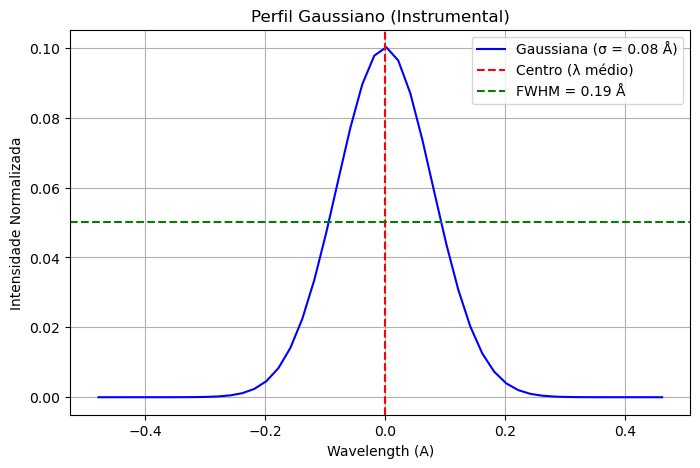

In [13]:
plot_gaussian_P(wavelength_synth, R)

In [14]:
# E = F (conv) P
# Convoluir o espectro sintético com a gaussiana
E_values = convolve(flux_synth, P_spectrum, mode='same')

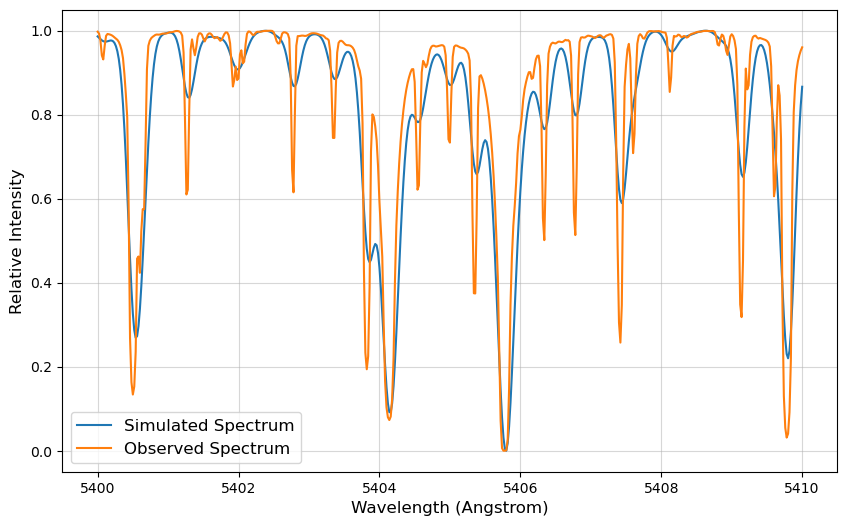

In [15]:
# Plot the spectra (Synthetic/Observed (F) and Instrumental (P)

# Define the wavelength range
min_wavelength = 5400
max_wavelength = 5410

# Create a mask for the wavelength range
mask = (wavelength_synth >= min_wavelength) & (wavelength_synth <= max_wavelength)

# Apply the mask to select the desired range
filtered_wavelength = wavelength_synth[mask]
filtered_flux_synth = flux_synth[mask]
filtered_simulated_flux = E_values[mask]

# Normalize the flux values to the range [0, 1]
normalized_flux_synth = (filtered_flux_synth - filtered_flux_synth.min()) / (filtered_flux_synth.max() - filtered_flux_synth.min())
normalized_simulated_flux = (filtered_simulated_flux - filtered_simulated_flux.min()) / (filtered_simulated_flux.max() - filtered_simulated_flux.min())

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(filtered_wavelength, normalized_simulated_flux, label="Simulated Spectrum")
plt.plot(filtered_wavelength, normalized_flux_synth, label="Observed Spectrum")

# Add labels, title, and legend
plt.xlabel("Wavelength (Angstrom)", fontsize=12)
plt.ylabel("Relative Intensity", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.show()


<b> Rotational Spectrum </b>

In [17]:
from scipy.constants import c
c

299792458.0

In [18]:
import numpy as np

def G(wavelength, epsilon, vsinI):
    """
    Calculate the rotational broadening profile G(Δλ).
    
    Parameters:
        vsinI: float
            Projected rotational velocity (in the same units as c).
        wavelength: array-like
            Wavelength array.
        epsilon: float
            Linear limb-darkening coefficient (0 to 1).
    
    Returns:
        array-like: Rotational profile G(Δλ).
    """
    # Vel.luz
    c=299792458.0 #m/s

    #Fatores eq
    central_wavelength = np.mean([wavelength.min(), wavelength.max()])
    delta_lambda_m = (central_wavelength * vsinI) / c

    # Step para intervalo
    pixel_size = wavelength[2] - wavelength[1]

    # Intervalo
    xx=np.arange(-delta_lambda_m,delta_lambda_m, pixel_size)

    # Fatores formula
    fator = (xx) / delta_lambda_m
    
    # Termos 
    term1 = 2 * (1 - epsilon) * np.sqrt(1 - fator**2)
    term2 = (np.pi * epsilon / 2) * (1 - fator**2)
    denominator = np.pi * delta_lambda_m * (1 - epsilon / 3)

    # Final result
    G_value = (term1 + term2) / denominator
    G_value = G_value/G_value.sum() #normalize
    
    return xx, G_value

In [19]:
xx, G_values = G(wavelength_synth, 0.5, 20000)

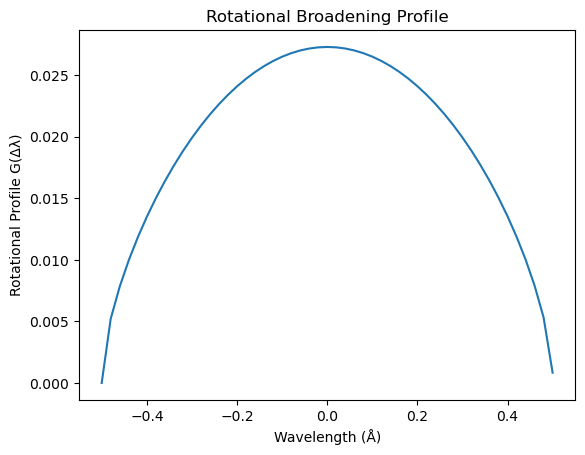

In [20]:
def plot_rotational_profile(xx, g_values):

    plt.title("Rotational Broadening Profile")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Rotational Profile G(Δλ)")
    plt.plot(xx,g_values)
    plt.show()

plot_rotational_profile(xx, G_values)

In [21]:
# Perform convolution (H = I (conv) P)
rotation_spectrum = convolve(flux_synth, G_values, mode='same')

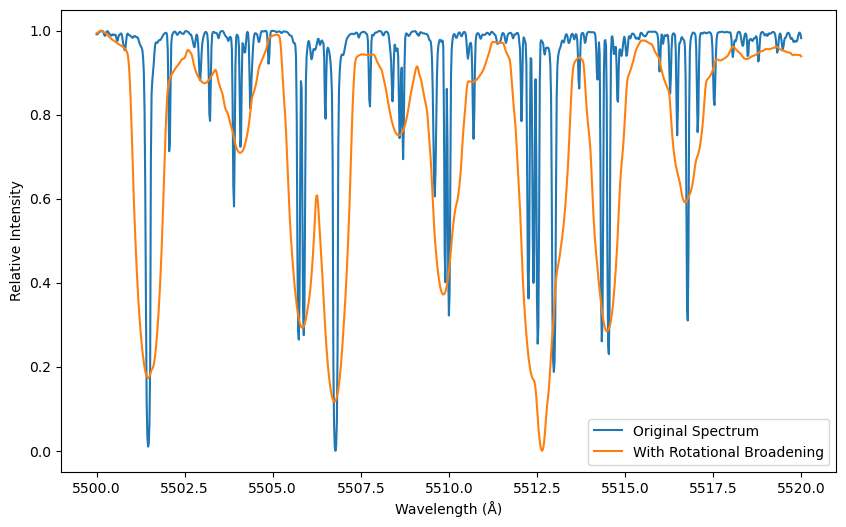

In [22]:
# Spectra comparison: Spectrum without Rotation vs Spectrum with Rotation
lambda_min = 5500
lambda_max = 5520

mask_real = (wavelength_synth >= lambda_min) & (wavelength_synth <= lambda_max)

wavelength_synth_filtered = wavelength_synth[mask_real]
rotation_flux_filtered = rotation_spectrum[mask_real]
filtered_flux_synth = flux_synth[mask_real]


# Normalize the flux values to the range [0, 1]
normalized_flux_synth = (filtered_flux_synth - filtered_flux_synth.min()) / (filtered_flux_synth.max() - filtered_flux_synth.min())
rotation_normalized = (rotation_flux_filtered - rotation_flux_filtered.min()) / (rotation_flux_filtered.max() - rotation_flux_filtered.min())

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(wavelength_synth_filtered, normalized_flux_synth, label="Original Spectrum")
plt.plot(wavelength_synth_filtered, rotation_normalized, label="With Rotational Broadening")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Relative Intensity")
plt.legend()
plt.show()

In [23]:
def plot_spectra(lambda_min, lambda_max, flux_1, flux_2, wavelength, flux_1_name, flux_2_name, x_axis_label=None, y_axis_label=None):

    # Mask to filter values between desired wavelengths
    mask_real = (wavelength >= lambda_min) & (wavelength <= lambda_max)

    #Apply mask to both spectra and wavelength arrays
    wavelength_filtered = wavelength[mask_real]
    flux_1_filtered = flux_1[mask_real]
    flux_2_filtered = flux_2[mask_real]

    # Normalize the flux values to the range [0, 1]
    normalized_flux_1 = (flux_1_filtered - flux_1_filtered.min()) / (flux_1_filtered.max() - flux_1_filtered.min())
    normalized_flux_2 = (flux_2_filtered - flux_2_filtered.min()) / (flux_2_filtered.max() - flux_2_filtered.min())

    # Plot the normalized data
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_filtered, normalized_flux_1, label=f"{flux_1_name}")
    plt.plot(wavelength_filtered, normalized_flux_2, label=f"{flux_2_name}")
    if(x_axis_label == None):
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Relative Intensity")
    else:
        plt.xlabel(f"{x_axis_label}")
        plt.ylabel(f"{y_axis_label}")  

    plt.legend()
    plt.show()
    

In [25]:
# Simulate synthetic spectrum
def simulate_spectrum(wavelength, resolution, vsinI, SNR, epsilon=0.6, c=c):
    
    flux = np.ones_like(wavelength)
    flux[2000:2020] -= 0.5  # Add an absorption line for demonstration
    
    # Apply rotational broadening
    G_profile = G(c, vsinI, wavelength, epsilon)
    flux_rotated = convolve(flux, G_profile, mode='same')
    
    # Apply instrumental broadening
    gaussian_kernel = P(wavelength, resolution)
    flux_broadened = convolve(flux_rotated, gaussian_kernel, mode='same')
    
    # Add noise to achieve the desired SNR
    signal = flux_broadened
    noise_std = np.mean(signal) / SNR
    noise = np.random.normal(0, noise_std, size=signal.shape)
    flux_noisy = signal + noise
    
    return wavelength, flux_noisy, flux_broadened